In [1]:
from importlib import reload
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import gan

cuda = torch.cuda.is_available()

print("Cuda: " + str(cuda))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Cuda: True
Cuda: True


In [2]:
latent_dim = 2
loaded_gen = gan.load_model("good_generator_81", layer_width=400, grid_length=9).eval()

for param in loaded_gen.parameters():
    param.requires_grad = False
    
grid_length = 9

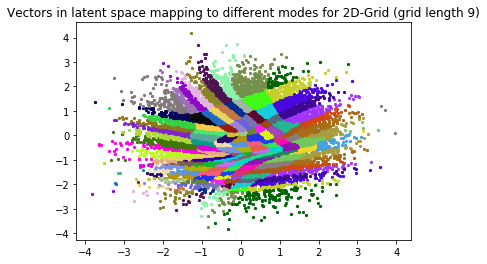

In [3]:
gan.visualize_latent_space(loaded_gen, latent_dim=latent_dim, grid_length=grid_length)

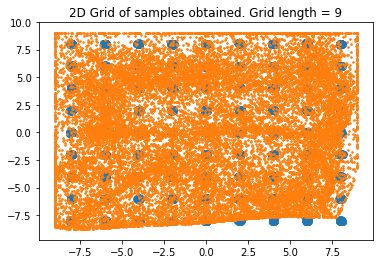

In [4]:
gan.visualize_model(loaded_gen, latent_dim=latent_dim, grid_length=grid_length)

Cuda: True
(0.051246576, array([[-1.4263654, -1.4560165]], dtype=float32))


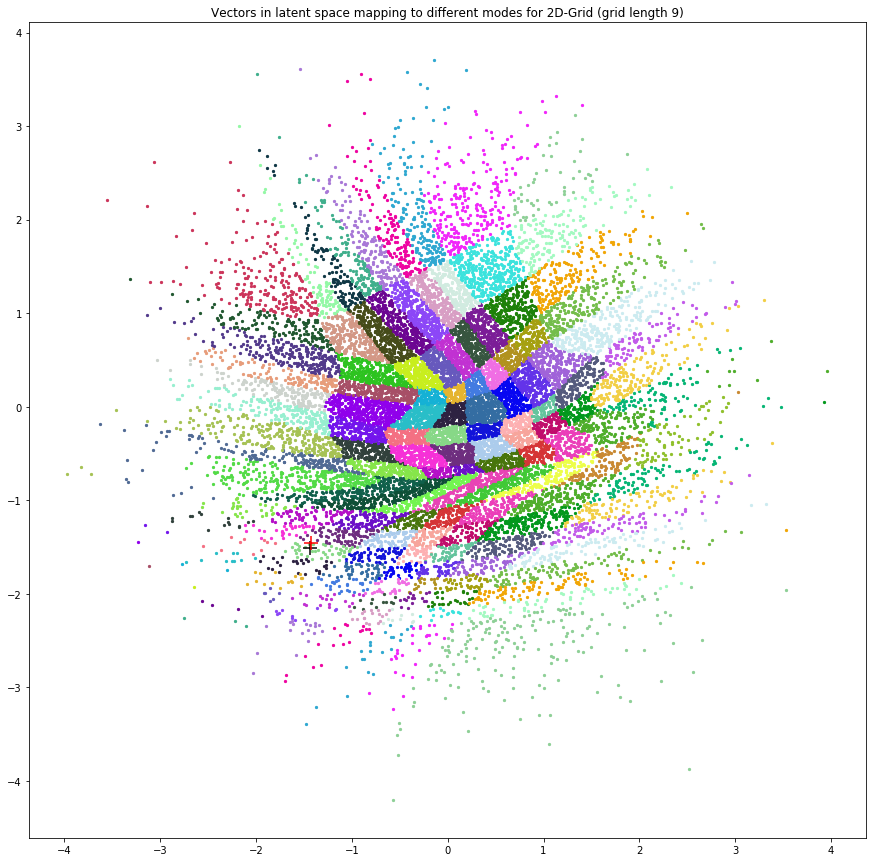

In [12]:
reload(gan)

plt.rcParams['figure.figsize'] = [15, 15]


plt.clf()

# sample a point z at random and record its classification
z = Variable(Tensor(np.random.normal(0, 1, (1, latent_dim))))
# znp = z.cpu().detach().numpy()
# znp_gan_eval = loaded_gen(z).cpu().detach().numpy()
# z_class = gan.point_to_index(znp_gan_eval, grid_length=grid_length)

# num_trials = 10
# dist = 0.0
# best_global_point = None
# for i in range(num_trials):
#     # sample a point z_prime at random with a different classification
#     z_prime = Variable(Tensor(np.random.normal(0, 1, (1, latent_dim))))
#     zpnp = z_prime.cpu().detach().numpy()
#     zpnp_gan_eval = loaded_gen(z_prime).cpu().detach().numpy()
#     z_prime_class = gan.point_to_index(zpnp_gan_eval, grid_length=grid_length)
#     while z_prime_class == z_class:
#         z_prime = Variable(Tensor(np.random.normal(0, 1, (1, latent_dim))))
#         zpnp = z_prime.cpu().detach().numpy()
#         zpnp_gan_eval = loaded_gen(z_prime).cpu().detach().numpy()
#         z_prime_class = gan.point_to_index(zpnp_gan_eval, grid_length=grid_length)

#     # print("[Z Class: %d] [Z prime Class: %d]" % (z_class, z_prime_class))
#     # print((znp, zpnp))
#     # display the two points on top of the latent space map

#     gan.visualize_latent_space(loaded_gen, latent_dim=latent_dim, grid_length=grid_length)

# #     plt.scatter(*zip(*z.cpu().detach().numpy()), c=(0.0, 0.0, 0.0), marker="+", s=200)
# #     plt.scatter(*zip(*z_prime.cpu().detach().numpy()), c=(0.0, 0.0, 0.0), marker="X", s=200)


#     # compute largest lamb s.t. lamb * z + (1 - lamb) * z_prime
#     # has a different classification index from z

#     high, low = 1.0, 0.0
#     lamb = 0.50
#     equal_eps = 0.0000001
#     while high > low + equal_eps:
#         lamb = (high + low) / 2.0
#         test_z = lamb * znp + (1 - lamb) * zpnp
#         test_z_tensor = Variable(Tensor(test_z))
#         test_z_eval = loaded_gen(test_z_tensor).cpu().detach().numpy()
#         test_z_class = gan.point_to_index(test_z_eval, grid_length=grid_length)
#         if test_z_class == z_class:
#             # this means that lamb is too high
#             high = lamb
#         else:
#             # this means that lamb is too low
#             low = lamb
#     best_point = lamb * znp + (1 - lamb) * zpnp
#     best_point_tensor = Variable(Tensor(best_point))
#     best_point_eval = loaded_gen(best_point_tensor).cpu().detach().numpy()
#     best_point_class = gan.point_to_index(best_point_eval, grid_length=grid_length)

#     # print((z_class, best_point_class))
#     d = np.linalg.norm(best_point - z)
#     if dist == 0:
#         dist = d
#         best_global_point = best_point.copy()
#     dist = min(dist, d)
#     if dist == d:
#         best_global_point = best_point.copy()

# print(dist)
gan.visualize_latent_space(loaded_gen, latent_dim=latent_dim, grid_length=grid_length)
dist, best_global_point = gan.gradient_free_radius(z, loaded_gen, latent_dim=latent_dim, grid_length=grid_length)
print((dist, best_global_point))

plt.scatter(*zip(*z.cpu().detach().numpy()), c=(0.0, 0.0, 0.0), marker="+", s=200)
plt.scatter(*zip(*best_global_point), c = (1.0, 0.0, 0.0), marker="+", s=200)

# sidenote: look into white box adversarial attacks